In [1]:
import os
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [2]:
#1. understand the problem 
#2.decide which model to use 
#3.messurement matrix 
#4.extra about collabe
#5.load data if you want to do it quit ofter just make a function for it i am not doing since it's already here. 

def load_housing_data():
    tar_file=Path('/home/kartiksavaliya/Desktop/Hands-On-  ML/handson-ml3-main/datasets/housing.tgz')
    return pd.read_csv(Path('/home/kartiksavaliya/Desktop/Hands-On-  ML/handson-ml3-main/datasets/housing/housing.csv'))

In [3]:
housing = load_housing_data()

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
#let's take a quick look at data how it organize and where to deal with it.
                                
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


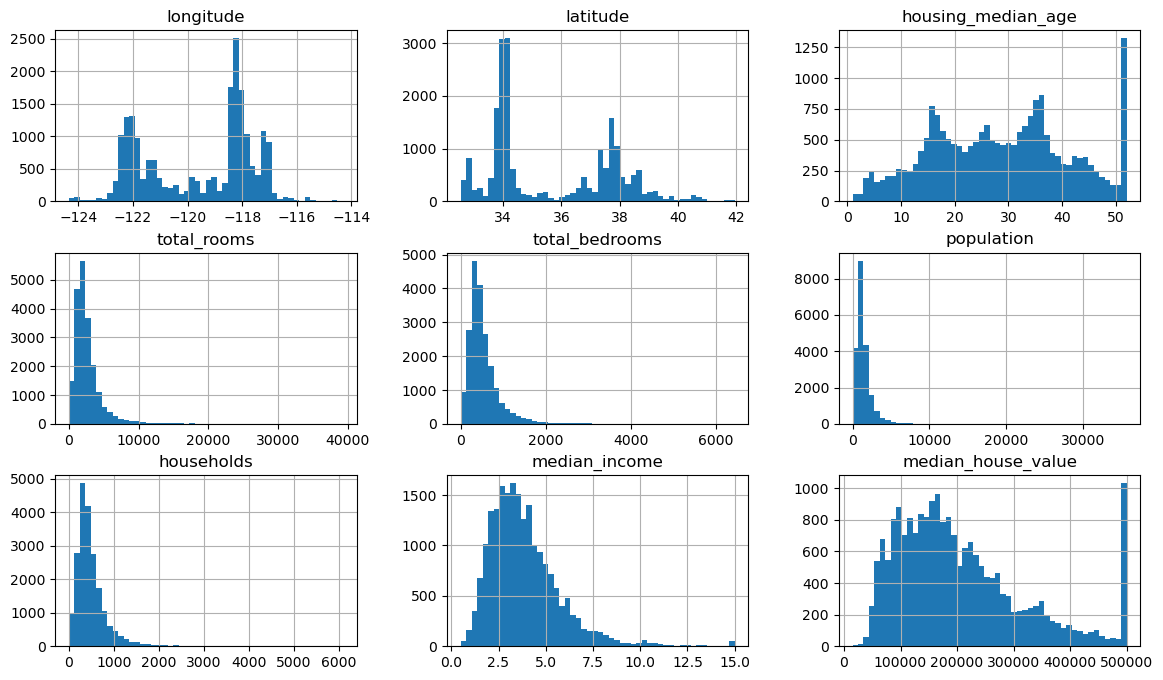

In [8]:
import matplotlib.pyplot as plt

housing.hist(bins=50,figsize=(14,8))
plt.show()

In [9]:
#6 TRAIN TEST SPLIT
# it's too early to use train test split but for the better understanding of data we have done this eralier ,
# also we have done random split but in order to not introduct bias we have split strtigically
#there are many ways to do this so we are exploring it in many cells.
from sklearn.model_selection import train_test_split

In [10]:
train_set,test_set = train_test_split(housing,test_size=0.2,random_state=42)

In [11]:
print(len(train_set))
print(len(test_set))

16512
4128


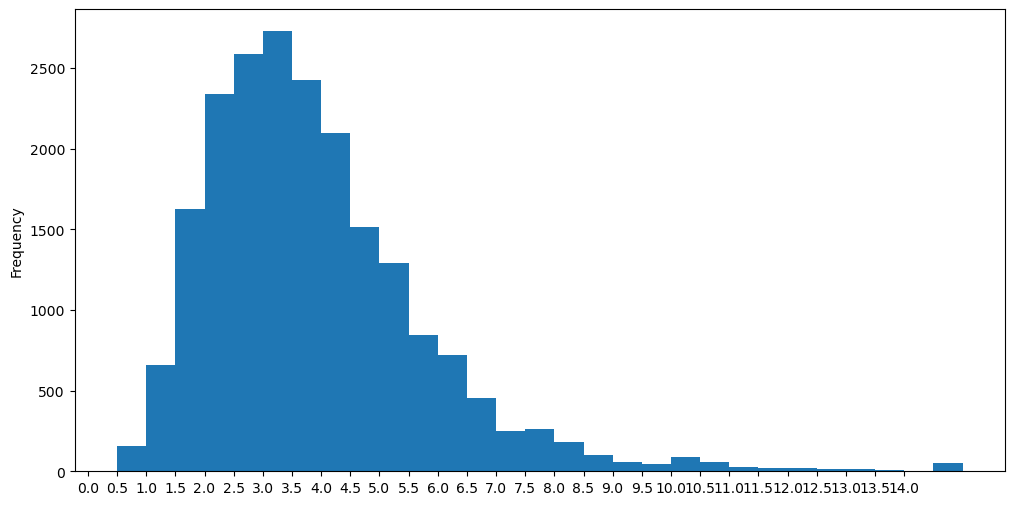

In [12]:
#zooming on median_income column with histogram.
import numpy as np
housing['median_income'].plot(kind='hist',bins=29,figsize=(12,6))
labels=np.linspace(0,14,29).round(1)
plt.xticks(labels)
plt.show()

In [13]:
#using pd.cut() func to convert income column into categorical column.
housing['income_cat']=pd.cut(housing['median_income'],bins=[0,1.5,3,4.5,6,np.infty],labels=['0-1.5','1.5-3','3-4.5','4.5-6','6-\u221E'])

<Axes: xlabel='income_cat'>

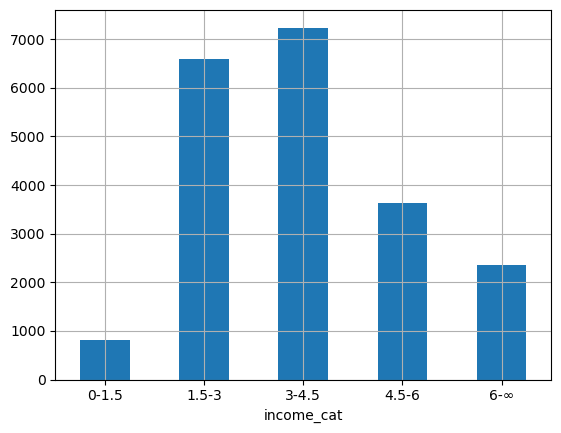

In [14]:
housing['income_cat'].value_counts().sort_index().plot(kind='bar',rot=0,grid=True)

In [15]:
#now let's create more than two sets with same ratio. but random elements in each sets. also it devide same portion of the lable column or
# column you want to. 
from sklearn.model_selection import StratifiedShuffleSplit
spliter=StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)
list=[]
for train_index,test_index in spliter.split(housing,housing['income_cat']):
    # print('train index :',train_index)
    # print('test index :',test_index)
    train_set_n=housing.iloc[train_index]
    test_set_n=housing.iloc[test_index]
    # print('train set :',train_set)
    # print('test set :',test_set)
    list.append([train_set,test_set])

train_set_1,test_set_1=list[0]
# print(train_set_1)
# print('test set' , test_set_1)

In [16]:
# if you just want 1 set train test split will do the job for you 
train_set_n,test_set_n=train_test_split(housing,test_size=0.2,random_state=42,stratify=housing['income_cat'])

In [17]:
print('overall proportion of income_cat column :\n',(housing['income_cat'].value_counts().sort_index())/len(housing))
print('\ntrainset proportion of income_cat column :\n',(train_set_n['income_cat'].value_counts().sort_index())/len(train_set_n))
print('\ntestset proportion of income_cat column :\n',(test_set_n['income_cat'].value_counts().sort_index())/len(test_set_n))

overall proportion of income_cat column :
 income_cat
0-1.5    0.039826
1.5-3    0.318847
3-4.5    0.350581
4.5-6    0.176308
6-∞      0.114438
Name: count, dtype: float64

trainset proportion of income_cat column :
 income_cat
0-1.5    0.039789
1.5-3    0.318859
3-4.5    0.350594
4.5-6    0.176296
6-∞      0.114462
Name: count, dtype: float64

testset proportion of income_cat column :
 income_cat
0-1.5    0.039971
1.5-3    0.318798
3-4.5    0.350533
4.5-6    0.176357
6-∞      0.114341
Name: count, dtype: float64


In [18]:
#we just created income_cat column to do this so let's drop it 
housing=housing.drop('income_cat',axis=1)
train_set_n=train_set_n.drop('income_cat',axis=1)
test_set_n=test_set_n.drop('income_cat',axis=1)

In [19]:
housing=train_set_n.copy()

In [20]:
housing['population'].describe()

count    16512.000000
mean      1425.513929
std       1094.795467
min          3.000000
25%        787.000000
50%       1167.000000
75%       1726.000000
max      16305.000000
Name: population, dtype: float64

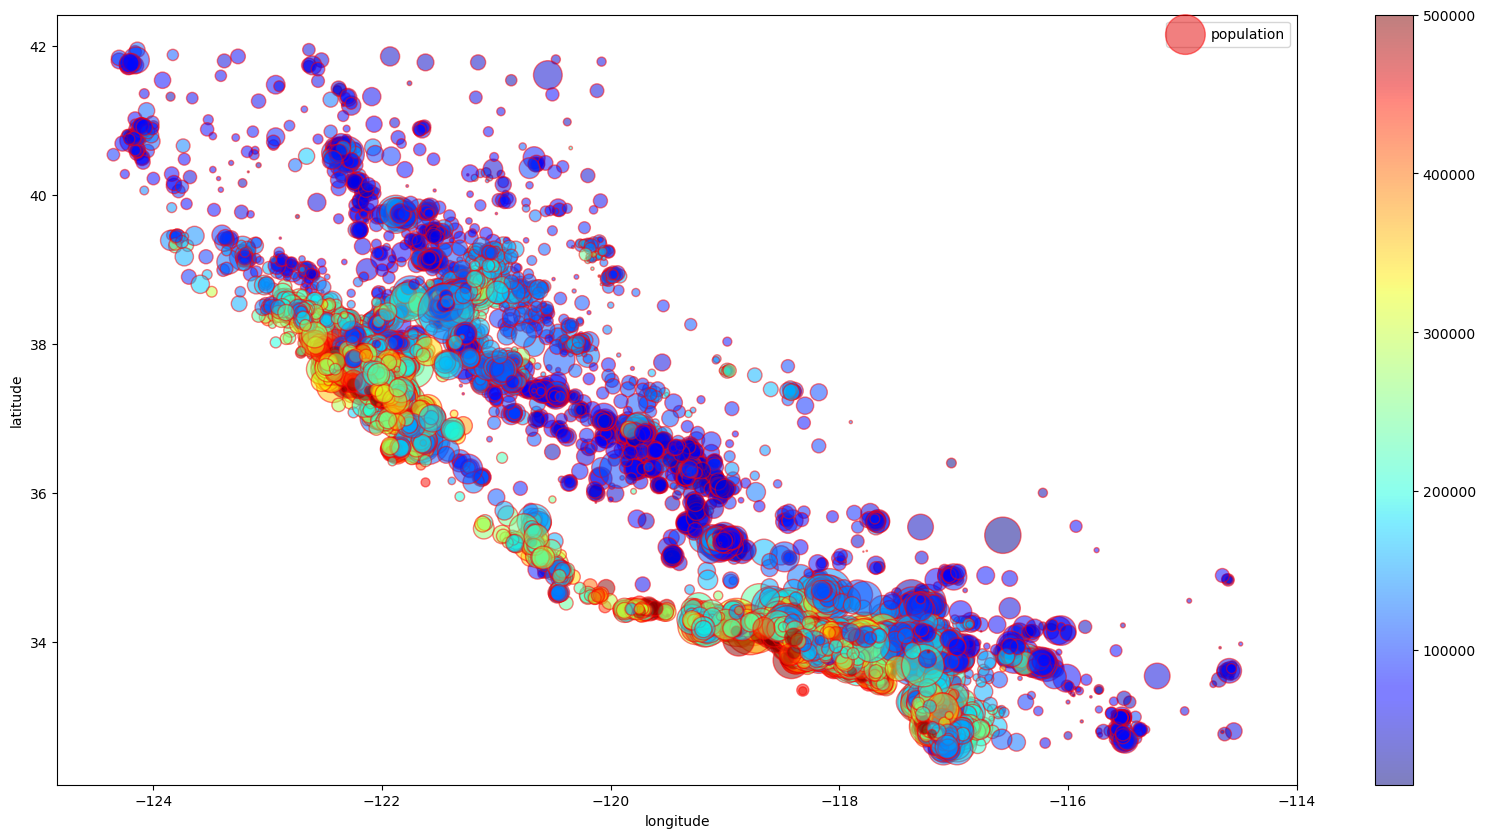

In [21]:
#EXPLORATION OF DATA
#now we really exploring the data and labels
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.5,s=housing['population']/10,label='population',colorbar=True,cmap='jet',
            c=housing['median_house_value'],edgecolors='red',figsize=(20,10),legend=True)
plt.show()

In [22]:
#it's a nice thing to see the corr between labels and other features
coormat=housing.corr(numeric_only=True)

In [23]:
coormat['median_house_value']


longitude            -0.050859
latitude             -0.139584
housing_median_age    0.102175
total_rooms           0.137455
total_bedrooms        0.054635
population           -0.020153
households            0.071426
median_income         0.688380
median_house_value    1.000000
Name: median_house_value, dtype: float64

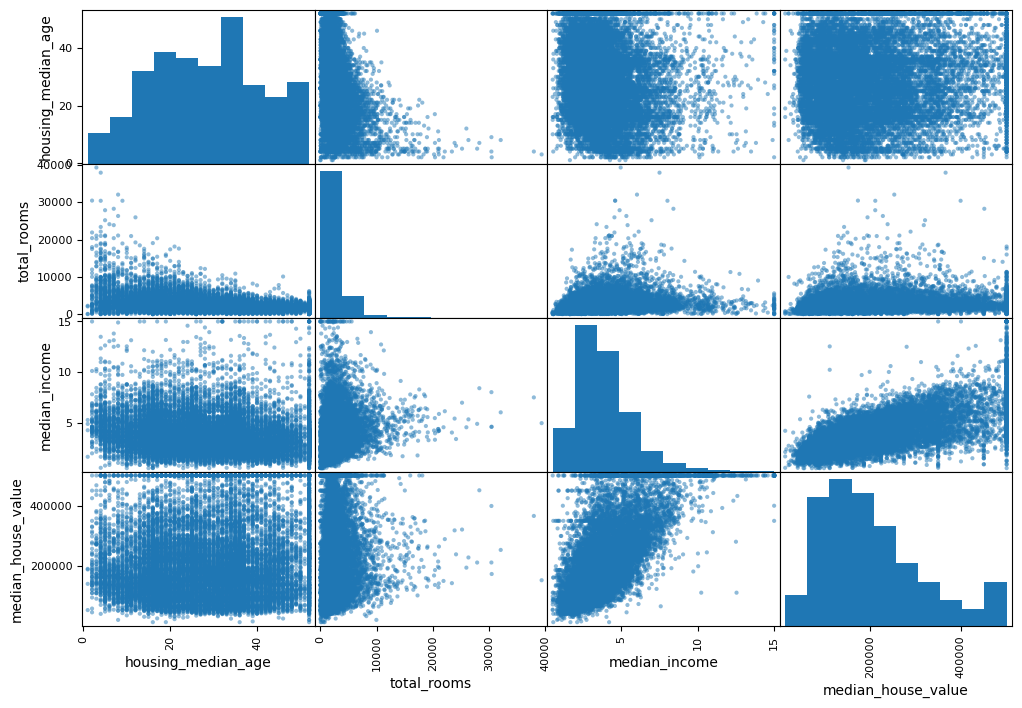

In [24]:
#now let's visulized the correlation using scatter_matrix func from pandas
# housing.info()
from pandas.plotting import scatter_matrix
plot_col=['housing_median_age','total_rooms','median_income','median_house_value']
scatter_matrix(housing[plot_col],figsize=(12,8))
plt.show()

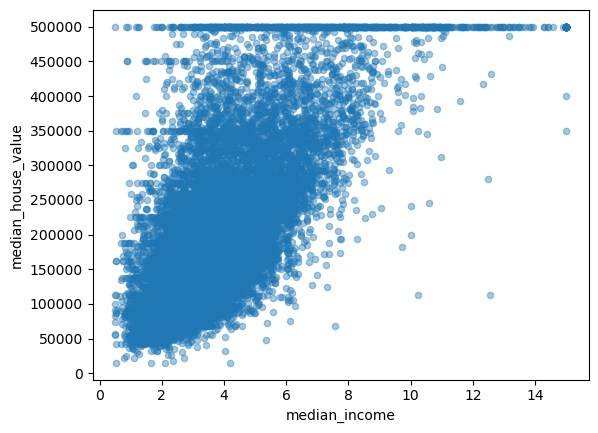

In [25]:
#since there is only one feature meadian income seems to relete the house value let's plot a scatter plot for it 
housing.plot(kind='scatter',x='median_income',y='median_house_value',alpha=0.4)
plt.yticks(np.linspace(0,500000,11))
plt.show()

In [26]:
# as we can see in our df the rooms , bedrooms , poplution given based on district but if it's in per person it will make more sence.
housing.head()
housing['rooms_per_house']=housing['total_rooms']/housing['households']
housing['bedroom_ratio']=housing['total_bedrooms']/housing['total_rooms']
housing['people_per_house']=housing['population']/housing['households']

In [27]:
housing.corr(numeric_only=True)['median_house_value']

longitude            -0.050859
latitude             -0.139584
housing_median_age    0.102175
total_rooms           0.137455
total_bedrooms        0.054635
population           -0.020153
households            0.071426
median_income         0.688380
median_house_value    1.000000
rooms_per_house       0.143663
bedroom_ratio        -0.256397
people_per_house     -0.038224
Name: median_house_value, dtype: float64

In [28]:
#now let's create x and y for model
housing_lable=train_set_n['median_house_value']
housing=train_set_n.drop('median_house_value',axis=1)

In [29]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [30]:
#HANDLING WITH MISSING DATA
#as you can see there are some missing values in total bedrooms column you can get rid of it using three methods of pandas 
# 1. drop the column containg missing values 
housing.drop('total_bedrooms',axis=1)
#2. remove whole row which cointain missing values for total bedrooms
housing.dropna(subset=['total_bedrooms'],inplace=True)
housing.info()
#3. this both methods at the end removing data from the df so we should be go with fill missing values with the median
housing=train_set_n.drop('median_house_value',axis=1)
median=housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median,inplace=True)
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16344 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16344 non-null  float64
 1   latitude            16344 non-null  float64
 2   housing_median_age  16344 non-null  float64
 3   total_rooms         16344 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16344 non-null  float64
 6   households          16344 non-null  float64
 7   median_income       16344 non-null  float64
 8   ocean_proximity     16344 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64

In [31]:
#but it is more mannual way and scarry too. so you can use the simpleimputer from sklearn to fill missing values in whole df by a method you want to 

from sklearn.impute import SimpleImputer
#creating a instace of imputer
imp = SimpleImputer(strategy='median')

#imputer only work on numberical data so excluding the other datatype you can also use include argument with 'number'
housing_num=housing.select_dtypes(exclude='object')
housing_num.info()

#then simply fit that df and it will generate the median for each column
imp.fit(housing_num)
print('median using imputer :\n',imp.statistics_)
print('median using numpy on df :\n',housing_num.median().values)


<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB
median using imputer :
 [-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
median using numpy on df :
 [-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


In [32]:
X=imp.transform(housing_num)
housing_tr=pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [33]:
#HANDLING TEXT AND CATEGORICAL DATA
#we are gone use ordinal encoder which convert this categories into values.
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder=OrdinalEncoder()
housing_cat=ordinal_encoder.fit_transform(train_set_n[['ocean_proximity']])
housing_cat

array([[3.],
       [0.],
       [1.],
       ...,
       [4.],
       [0.],
       [4.]])

In [34]:
# as you can see it's numbers are not releted here but model will recognized as releted so we use onehotencode to transform this into 0-1
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder()
housing_cat_1hot=one_hot_encoder.fit_transform(housing_cat)
# print(housing_cat_1hot)
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [35]:
#well it was a array which is not much meaning full so let's convert this array into dataframe.
one_hot_encoder = OneHotEncoder(sparse_output=False)
housing_cat_arr=one_hot_encoder.fit_transform(train_set_n[['ocean_proximity']])
housing_cat_df = pd.DataFrame(housing_cat_arr,columns=one_hot_encoder.get_feature_names_out(),index=train_set_n.index)
housing_cat_df.head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,0.0,0.0,0.0,1.0,0.0
14973,1.0,0.0,0.0,0.0,0.0
3785,0.0,1.0,0.0,0.0,0.0
14689,0.0,1.0,0.0,0.0,0.0
20507,0.0,0.0,0.0,0.0,1.0


In [36]:
# FEATURE SCALING AND TRASFORMATION 
# 1.using minmaxscaler
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler(feature_range=(-1,1))
housing_num_minmax_scale=minmaxscaler.fit_transform(housing_num)

# 2.using standrd scaler
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
housing_num_standard_scale=standardscaler.fit_transform(housing_num)

In [37]:
# tailed distribution - both method failed because both method will distroy the outlier or model predictions
# Solution - try to make distribution symetric 
# Ways to do that - 1. positive features with tail to right -- replace feature with it's values of power between 0 to 1 ex (sqrt) 
# 2. heavy tail -- try to use log scale 
# 3. devide the values in bucket just like we did when create income category column 
# 4. multimodel distribution ⅰ.using bucket but must use OneHotIncoder 
# ⅱ. add a feature for each mode - achieving using radial basis function (RBF) 
# most comman is gaussian RBF : exp(-γ(x-35)²) -- as the values goes far from 35 it will decrease fast.

from sklearn.metrics.pairwise import rbf_kernel
housing_age_rbf_35=rbf_kernel(train_set_n[['housing_median_age']],[[35]],gamma=.1)

In [38]:
# since we are studying the transformation if we transform the label data how we understand the real values here inverse transform func come to play.
scaler =StandardScaler()
labels=scaler.fit_transform(housing_lable.to_frame())
# print(labels)
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(housing[['median_income']],labels)

pred = model.predict(housing[['median_income']][:5])
scaler.inverse_transform(pred)

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [39]:
# well we can do all the things just by one function not need to go this long way 

from sklearn.compose import TransformedTargetRegressor

model =TransformedTargetRegressor(LinearRegression(),transformer=StandardScaler())
model.fit(housing[['median_income']],housing_lable)

model.predict(housing[['median_income']][:5])

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [40]:
# Now let's see how you can create you own tranfrom func. Many time you needs to create you own transformation func for various transformation
from sklearn.preprocessing import FunctionTransformer

#example of use case of Function Trasformer
log_transformer = FunctionTransformer(np.log,np.exp)
log_values = log_transformer.transform(housing['housing_median_age'])
# print(housing['housing_median_age'])
log_values

ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

#you can also create new transfomer from a old transformer and give parameter of the old one in new as a fix values 
rbf_transformer = FunctionTransformer(rbf_kernel,
kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

# 

In [41]:
# We just see how to use transform , but what if we also want to use fit and trasform both function here by inherting a class we can do that.

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.base import check_array,check_is_fitted

class StandardScalerClone(BaseEstimator,TransformerMixin):
    def __init__(self,with_mean=True):
        self.with_mean=with_mean

    def fit(self,X,y=None):
        X=check_array(X)
        self.mean_=X.mean()
        self.std_=X.std()
        self.n_features_in_=X.shape[1]
        return self
        
    def transform(self,X):
        check_is_fitted(self)
        X=check_array(X)
        assert self.n_features_in_==X.shape[1]
        if self.with_mean:
            X=X-self.mean_
        return X/self.std_

#well the thing to note here is we don't use func like : inverse_transform(),get_feature_names_in(),get_features_name_out() but we have to 
# whenever we build own transformer. 

In [42]:
stdscaler=StandardScalerClone()
stdscaler.fit(housing_num)

StandardScalerClone()

In [43]:
stdscaler.n_features_in_

8

In [44]:
stdscaler.transform(housing_num)

array([[-0.59916821, -0.47182066, -0.46053408, ...,  0.75078579,
         0.3199883 , -0.5001971 ],
       [-0.5959571 , -0.47472973, -0.47007203, ...,  0.02749112,
        -0.21811114, -0.4970266 ],
       [-0.59881848, -0.47137555, -0.47563584, ..., -0.05517113,
        -0.34051485, -0.49993139],
       ...,
       [-0.59490792, -0.47596172, -0.49153242, ...,  1.73478448,
         0.10220507, -0.49863693],
       [-0.595973  , -0.47479332, -0.47245652, ...,  0.86921536,
         0.16420176, -0.49857024],
       [-0.59916026, -0.47193193, -0.46689272, ...,  0.04020839,
        -0.33336139, -0.49925554]])

In [45]:
#Also custom trasformer can use other estimator 
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # always return self!
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [46]:
#PIPELINE
# as you can see you have to do many transformation in right order here pipeline comes to play
import sklearn as sklearn
sklearn.set_config(display="diagram")
from sklearn.pipeline import Pipeline

imp_stdscaler_pip=Pipeline([('imputer',SimpleImputer(strategy='median')),('scaler',StandardScaler())])

# things to note 1.name can be anything just two limits --unique names --not __ (double underscore)
# 2.in pipeline you can pass as many as arguments you want but all must be trasfomer except last one it can be anything(predictor,estimator..)

imp_stdscaler_pip

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [47]:
# However if you don't want to use the names you can use make_pipeline() function 
# just using .fit() you can do fit and transform.

from sklearn.pipeline import make_pipeline

imp_stdscaler_pip2=make_pipeline(SimpleImputer(strategy='median'),StandardScaler())
imp_stdscaler_pip2

#if the last method is predictor you use .predict() - do all trasformation and predict.
#if last method is trasfomer you use .transform() - do all transformation.

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [48]:
# pipline also have get_feature_names_out() func which is usefull for creating df out of array.
housing_tr_arr=imp_stdscaler_pip.fit_transform(housing_num)
housing_tr_df=pd.DataFrame(housing_tr_arr,columns=imp_stdscaler_pip.get_feature_names_out(),index=housing_num.index)
housing_tr_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


In [49]:
#pipeline also support indexing
imp_stdscaler_pip[:-1]
imp_stdscaler_pip.named_steps

{'imputer': SimpleImputer(strategy='median'), 'scaler': StandardScaler()}

In [50]:
# Now as we have seen we have to handle cat and num columns seprate but what if some pipeline do that 
cat_pip=make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder())

housing=pd.read_csv('/home/kartiksavaliya/Desktop/Hands-On-  ML/handson-ml3-main/datasets/housing/housing.csv')
num_col=housing.columns[:-1]
cat_col=housing.columns[-1]

from sklearn.compose import ColumnTransformer

transformer=ColumnTransformer([('num_pip',imp_stdscaler_pip,num_col),('cat_pip',cat_pip,cat_col)])
transformer

ColumnTransformer(transformers=[('num_pip',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')),
                                ('cat_pip',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 'ocean_proximity')])

In [51]:
# there is still some function we can use instead of doing things manually
from sklearn.compose import make_column_selector,make_column_transformer

transformer1=make_column_transformer((imp_stdscaler_pip,make_column_selector(dtype_exclude='object')),
                                    (cat_pip,make_column_selector(dtype_include='object')))

housing_tr1=transformer1.fit_transform(housing)

In [52]:
# So far we have seen how to use transformer and pipeline now let's make some functions to do this repeted things 

def column_ratio(X):
    return X[:,[0]]/X[:,[1]]

def ratio_name(function_transformer,feature_names_in):
    return ['ratio']

def ratio_pipeline():
    return make_pipeline(SimpleImputer(strategy='median'),
                         FunctionTransformer(column_ratio,feature_names_out=ratio_name),
                         StandardScaler())

log_pipeline=make_pipeline(SimpleImputer(strategy='median'),
                           FunctionTransformer(np.log,feature_names_out='one-to-one'),
                           StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
StandardScaler())

processing=ColumnTransformer([
("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
("people_per_house", ratio_pipeline(), ["population", "households"]),
("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
"households", "median_income"]),
("geo", cluster_simil, ["latitude", "longitude"]),
("cat", cat_pip, make_column_selector(dtype_include=object)),
],
remainder=default_num_pipeline)


In [53]:
housing_final=processing.fit_transform(housing)

/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [54]:
processing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age', 'remainder__median_house_value'],
      dtype=object)

In [55]:
y=train_set_n['median_house_value']
train_set_n.drop('median_house_value',axis=1,inplace=True)

In [56]:
#SELECT AND TRAIN A MODEL 
from sklearn.linear_model import LinearRegression

housing_lable=housing['median_house_value']
lin_pip = make_pipeline(processing,LinearRegression())
lin_pip.fit(train_set_n,y)

/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7ec...
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ec43bd69d80>)])),
                ('linearregression', LinearRegression())])

In [57]:
# y_origional=test_set_n['median_house_value']
# test_set_n.drop('median_house_value',inplace=True,axis=1)
pred = lin_pip.predict(train_set_n)
pred

array([242761.81285712, 375862.7850295 , 127480.98273406, ...,
       189944.6422918 , 309509.08599798, 253541.89776216])

In [58]:
housing_lable

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

In [59]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y,pred,squared=False)

68647.95686706669

In [60]:
# as you can see the error is very high so you have to use other model to see which works better on this data

from sklearn.tree import DecisionTreeRegressor

dec_pip=make_pipeline(processing,DecisionTreeRegressor(random_state=42))

dec_pip.fit(train_set_n,y)

/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7ec...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ec43bd69d80>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [61]:
pred=dec_pip.predict(train_set_n)
mean_squared_error(y,pred,squared=False)

0.0

In [62]:
# we have use whole data to predict the model but it is better to use train test split and even better cross validation 
from sklearn.model_selection import cross_val_score

cross_validation_dic=-cross_val_score(dec_pip,train_set_n,y,scoring="neg_root_mean_squared_error",cv=10)

/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kme

In [63]:
pd.Series(cross_validation_dic).describe()

count       10.000000
mean     67153.318273
std       1963.580924
min      63925.253106
25%      66083.277180
50%      66795.829871
75%      68074.018403
max      70664.635833
dtype: float64

In [64]:
# as you can see it perform same as linear regression model now let's try random forest model and see how it works on data 

from sklearn.ensemble import RandomForestRegressor

ran_pip=make_pipeline(processing,RandomForestRegressor(random_state=42))

cross_validation_ran=-cross_val_score(ran_pip,train_set_n,y,scoring='neg_root_mean_squared_error',cv=10)
cross_validation_ran

/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kme

array([46405.71244442, 47292.32316869, 45667.06403642, 46760.29604849,
       45671.39170924, 46983.8625732 , 47222.52574811, 49354.7055139 ,
       47468.95051432, 47202.48530276])

In [87]:
pd.Series(cross_validation_ran).describe()

count       10.000000
mean     47002.931706
std       1048.451340
min      45667.064036
25%      46494.358345
50%      47093.173938
75%      47274.873814
max      49354.705514
dtype: float64

In [75]:
# GRID SEARCH CV - use for selecting best parameters for models AKA fine tuning 
from sklearn.model_selection import GridSearchCV

ran_grid_pip=Pipeline([('preprocessing',processing),('random_forest',RandomForestRegressor(random_state=42))])

param_grid = [
{'preprocessing__geo__n_clusters': [5, 8, 10],
'random_forest__max_features': [4, 6, 8]},
{'preprocessing__geo__n_clusters': [10, 15],
'random_forest__max_features': [6, 8, 10]},
]

grid_search=GridSearchCV(ran_grid_pip,param_grid=param_grid,scoring='neg_root_mean_squared_error',cv=3)
grid_search.fit(train_set_n,y)

/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kme

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ec43bd69d80>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [78]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [79]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7ec43bd...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ec43387e9e0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [86]:
grid_result=pd.DataFrame(grid_search.cv_results_)
grid_result

grid_result.sort_values(by='mean_test_score',ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,7.280059,1.377034,0.162889,0.026855,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43535.728124,-43753.147171,-44568.889283,-43952.588193,444.738152,1
13,11.482639,0.025928,0.164741,0.002431,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-44084.115907,-44204.924326,-44862.665796,-44383.902009,342.110841,2
14,12.209782,2.187830,0.166870,0.032712,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-44367.841163,-44496.254950,-45199.975902,-44688.024005,365.780976,3
7,8.253184,1.441970,0.191162,0.027901,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44250.873441,-44628.321123,-45857.123289,-44912.105951,685.764787,4
9,8.131214,1.102578,0.194433,0.041217,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44250.873441,-44628.321123,-45857.123289,-44912.105951,685.764787,4


In [99]:
# Random search is usefull when you have many parameter to test it selects random combo . think when you have continues values it help there.

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
'random_forest__max_features': randint(low=2, high=20)}

random_search=RandomizedSearchCV(ran_grid_pip,param_distribs,scoring='neg_root_mean_squared_error',cv=3,random_state=42)
random_search.fit(train_set_n,y)

/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kartiksavaliya/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/cluster/_kme

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ec4329aaad0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ec4329aba30>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [104]:
pd.DataFrame(random_search.cv_results_).sort_values('mean_test_score',ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,12.658349,0.757792,0.209911,0.024537,45,9,"{'preprocessing__geo__n_clusters': 45, 'random...",-41115.228179,-42150.560258,-42695.388036,-41987.058824,655.375634,1
8,9.709541,1.597399,0.191380,0.012850,32,7,"{'preprocessing__geo__n_clusters': 32, 'random...",-41603.581469,-42199.816021,-43219.472170,-42340.956553,667.191215,2
0,21.492570,0.948148,0.265914,0.085325,41,16,"{'preprocessing__geo__n_clusters': 41, 'random...",-42105.685594,-42742.754514,-43442.575824,-42763.671977,545.983533,3
5,7.249679,0.015638,0.219505,0.000381,42,4,"{'preprocessing__geo__n_clusters': 42, 'random...",-41811.758731,-42925.159968,-43557.196219,-42764.704973,721.548040,4
2,11.883782,0.243323,0.172132,0.027138,23,8,"{'preprocessing__geo__n_clusters': 23, 'random...",-42420.543545,-43094.390408,-43856.210711,-43123.714888,586.475346,5
